In [33]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from numpy.random import poisson, lognormal
from skbio.stats.composition import closure, clr
from gemelli.preprocessing import rclr
from gemelli.matrix_completion import MatrixCompletion
from IPython.core.display import HTML
%matplotlib inline

In [4]:
#fix font-size
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.5em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")

## Robust Aitchison and Subcompositional Coherence 
 

We skip over the use of matrix completion here, but for a primer on the methodology see [here](https://github.com/asberk/matrix-completion-whirlwind/blob/master/matrix_completion_master.ipynb). The exact method used here, OptSpace can be found [here](https://arxiv.org/pdf/0906.2027.pdf).

Example from ["A Concise Guide to Compositional Data Analysis"](http://www.leg.ufpr.br/lib/exe/fetch.php/pessoais:abtmartins:a_concise_guide_to_compositional_data_analysis.pdf) by John Aitchison
(page 21-22)

Consider the simple data set with $[x_1, x_2, x_3, x_4]$ features and three samples



In [7]:
X =  np.array([[100, 200, 100, 600],
              [200, 100, 100, 600],
              [300, 300, 200, 200]])
X

array([[100, 200, 100, 600],
       [200, 100, 100, 600],
       [300, 300, 200, 200]])

The full composition A is demonstrated below with $corr(x_1,x_2)=0.5$

In [8]:
A = closure(X)
A

array([[0.1, 0.2, 0.1, 0.6],
       [0.2, 0.1, 0.1, 0.6],
       [0.3, 0.3, 0.2, 0.2]])

In [9]:
pearsonr(A[:,0],A[:,1])[0]

0.4999999999999997

Now let's consider the subcompositon of x with $x_4$ missing so define B = $[x_1, x_2, x_3]$. We now get $corr(x_1,x_2)=-1.0$

In [10]:
B = closure(X[:,:-1])
B

array([[0.25 , 0.5  , 0.25 ],
       [0.5  , 0.25 , 0.25 ],
       [0.375, 0.375, 0.25 ]])

In [11]:
pearsonr(B[:,0],B[:,1])[0]

-0.9999999999999998

There is thus incoherence of the product-moment correlation between raw components as a measure of dependence.

Note, however, that the log ratio of two components remains unchanged when we move from full composition to subcomposition. For example

In [12]:
np.log(X[:,0])-np.log(X[:,1])

array([-0.69314718,  0.69314718,  0.        ])

In [13]:
np.log(X[:,:-1][:,0])-np.log(X[:,:-1][:,1])

array([-0.69314718,  0.69314718,  0.        ])

This can be further shown by the clr transform on a slightly larger dataset. We we will construct a dataset with three features all sampled in time. The first feature is lowly abundant but exponentially increasing in time. The second feature is highly abundant and constant in time. Finally, the third feature highly abundant and is stochastic in time. 


clr transformation is given by:

$clr(\vec{x}) = [log(\frac{x_i}{g(\vec{x})}) , ... , log(\frac{x_D}{g(\vec{x})})] = log(\vec{x}) - \bar{log(\vec{x})}$

where $g(\vec{x})$ is the geometric mean of all the features.


In [14]:
n = 100
t = np.linspace(1, 10, n)
x1 = np.exp(t) * 0.001
x2 = np.random.normal(size=n) + 100
x3 = np.random.normal(size=n) * 10 + 100
X = np.vstack((x1, x2, x3)).T
X.shape

(100, 3)

To visualize this we will plot counts by time colored by feature. 

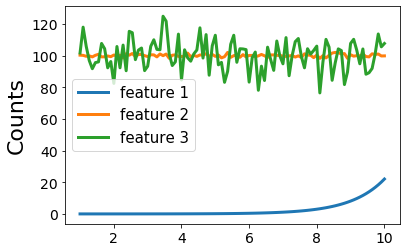

In [15]:
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.plot(t, x1, label='feature 1',lw=3)
plt.plot(t, x2, label='feature 2',lw=3)
plt.plot(t, x3, label='feature 3',lw=3)
plt.legend() 
plt.ylabel('Counts', fontsize=22)
plt.legend(prop={'size': 15})
plt.show()

The full compositions A is demonstrated below with $corr(x_1,x_2)=-0.5$ while the clr equivalent A_clr is $corr(x_1,x_2)=-1.0$

In [16]:
A_clr = clr(X)
A = closure(X)
A.shape


(100, 3)

In [17]:
pearsonr(A[:,0],A[:,-1])[0]

-0.4395726886624804

In [18]:
pearsonr(A_clr[:,0],A_clr[:,-1])[0]

-0.9984897720224686

Now let's consider the subcompositon of x with $x_2$ missing so define B = $[x_1, x_3]$. We now get $corr(x_1,x_2)=-1.0$ for both B the closed matrix and B_clr the clr transformed matrix.

In [19]:
B_clr = clr(X[:,[0,2]])
B = closure(X[:,[0,2]])
B.shape

(100, 2)

In [20]:
pearsonr(B[:,0],B[:,1])[0]

-0.9999999999999999

In [21]:
pearsonr(B_clr[:,0],B_clr[:,1])[0]

-0.9999999999999999

Indeed, clr is compositionally coherent and performs the same on sub-samples of the data. 

Now consider the problem where the matrix has missing values, that are typically coerced to zero values. Here we will generate A which is the same as the X we constructed above (but with more features) and then we will construct B which will be only ~77% filled in (the missing values converted to zero). 

In [22]:
n = 200
t = np.linspace(1, 10, n)
x1 = np.exp(t) * 0.001
x2 = np.random.normal(size=n) + 100
x3 = np.random.normal(size=n) * 10 + 100
A = np.vstack((np.vstack((x1, x2, x3) for x_ in range(3000)))).T
# subsample
mu = A.sum(axis=0)/1.5 * closure(A.T).T
B = np.vstack([poisson(lognormal(np.log(mu[:, i]), 1))
                     for i in range(A.shape[1])]).T.astype(float)
#how dense?
B.shape


/Users/cmartino/miniconda3/envs/qiime2-example-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


(200, 9000)

First we see in A that the plot is the same as above.

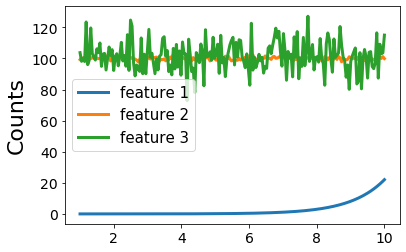

In [23]:
plt.plot(t, A[:,0], label='feature 1',lw=3)
plt.plot(t, A[:,1], label='feature 2',lw=3)
plt.plot(t, A[:,2], label='feature 3',lw=3)
plt.legend() 
plt.ylabel('Counts', fontsize=22)
plt.legend(prop={'size': 15})
plt.show()

Indeed, we can check the density of B and see that is is missing values.

In [24]:
np.count_nonzero(B)/(B.shape[0]*B.shape[1])

0.7876288888888889

Similarly, the plot now looks very different even with only ~22% of the data missing.

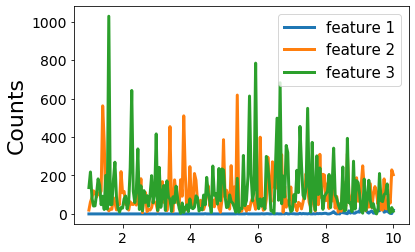

In [25]:
plt.plot(t, B[:,0], label='feature 1',lw=3)
plt.plot(t, B[:,1], label='feature 2',lw=3)
plt.plot(t, B[:,2], label='feature 3',lw=3)
plt.legend() 
plt.ylabel('Counts', fontsize=22)
plt.legend(prop={'size': 15})
plt.show()

First we will see if the compositional coherent properties of the clr transform hold in this case. In order to take the clr transform of B we must add a pseudo count of 1.

In [26]:
A_ = clr(A)
B_ = clr(B[:,:-1]+1)

In [27]:
pearsonr(A_[:,0],A_[:,1])[0]

-0.9985400321303127

In [28]:
pearsonr(B_[:,0],B_[:,1])[0]

-0.20738514393828678

We see that indeed the pseudo count does not retain the coherent result we saw earlier. This is evident that A has $corr(x_1,x_2)=-1.0$ while B does not.


Now we will try this using a robust-clr transform, given by:

$rclr(\vec{x}) = [log(\frac{x_i}{g(\vec{x})}) , ... , log(\frac{x_D}{g(\vec{x})})] = log(\vec{x_{ij}}) - \bar{log(\vec{x_j})} - \bar{log(\vec{x_j})}$

where $$g(\vec{x}) = (\prod_{i\varepsilon\Omega_{x}} x_i)^{1/\Omega_{x}} $$ 

and $\Omega_x$ is the is the set of observed features in sample x and $g_r(x)$ is the geometric mean only defined on observed features. 

followed by matrix completion, given by the following objective function where $Y=rclr(\vec{x})$:


$$ min_{u,v}|\Lambda(Y-UsV^{T})|_{2}^{2}  $$

where U and V are the matrices that are trying to be estimated and S is analogous to a matrix of eigenvalues. Y is the observed values and $\Lambda$ is a function such that the errors between Y and USV are only computed on the nonzero entries.


In [34]:
A_ = rclr(A)
U,s,V = MatrixCompletion().fit_transform(A_)
A_ = np.dot(np.dot(U,s),V.T)

B_ = rclr(B[:,:-1])
U,s,V = MatrixCompletion().fit_transform(B_)
B_ = np.dot(np.dot(U,s),V.T)


/Users/cmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:144: RuntimeWarning: divide by zero encountered in log
  M_log = np.log(M_log.squeeze())


In [35]:
pearsonr(A_[:,0],A_[:,1])[0]

-0.9985400321303125

In [36]:
pearsonr(B_[:,0],B_[:,1])[0]

-0.9123795455323517

This reconstructs the trend we saw before where B is again compositionally coherent even with sparsity with approximately ~ $corr(x_1,x_2)=-1.0$. Indeed, in this toy example we are able to approximate A with the robust clr transform in combination with matrix completion. We can show that this even holds for very small subsets of the features.

In [37]:
num_features = []
corr_ = []
for i in np.linspace(1,int(B.shape[1]/1.2),5):
    i = int(i)
    num_features.append(B[:,:-(i+1)].shape[1])
    B_ = rclr(B[:,:-(i+1)])
    U,s,V = MatrixCompletion().fit_transform(B_)
    B_ = np.dot(np.dot(U,s),V.T)
    corr_.append(pearsonr(B_[:,0],B_[:,1])[0])
    

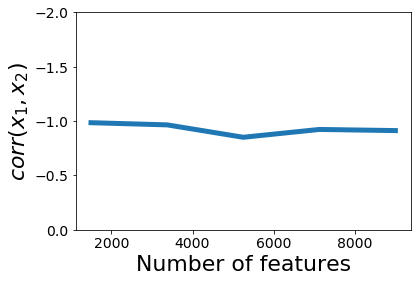

In [38]:
plt.plot(num_features[::-1],
         corr_[::-1], lw=5)
plt.ylim(0,-2)
plt.xlabel('Number of features', fontsize=22)
plt.ylabel('$corr(x_1,x_2)$',  fontsize=22)
plt.show()

